In [25]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import math 
import torch.nn.functional as F
from dataclasses import dataclass
from jaxtyping import Float, Int
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from get_books import get_gutenberg_book, get_many_books
from transformers import AutoTokenizer  # for tokenization
from torch.nn import GELU  

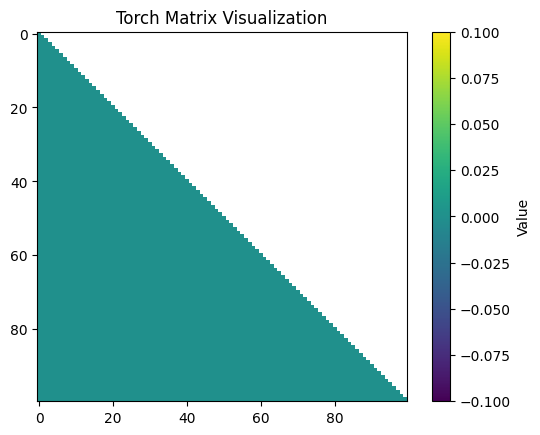

In [26]:
# def create_mask(n_context: int) -> Float[torch.Tensor, "n_context n_context"]:
def create_mask(n_context: int) -> torch.Tensor:
    mask = torch.zeros(n_context, n_context)
    indices = torch.triu_indices(n_context, n_context, offset=1)
    mask[indices[0], indices[1]] = float('-inf')
    
    return mask



# Create a random 5x5 matrix
M = create_mask(100)

# Convert to NumPy for visualization
M_np = M.numpy()

# Plot the matrix
plt.imshow(M_np, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Torch Matrix Visualization")
plt.show()

In [27]:
@dataclass
class GPTConfig:
	d_vocab: int = 10_000
	d_model: int = 128
	d_mlp: int = 512
	n_heads: int = 4
	d_head: int = 32
	n_layers: int = 6
	act_fn: type[nn.Module] = nn.ReLU

# note: the residual stream is `n_context` by `d_model`

# this is the row-wise (last dimension) softmax of x
# F.softmax(x, dim=-1)

class AttentionHead(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.W_Q = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_K = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_O = nn.Linear(cfg.d_head, cfg.d_model) # fix this later
		self.W_V = nn.Linear(cfg.d_model, cfg.d_head)
		

		

	def forward(self, x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		#hidden = self.embedding(x)
		# n_context = x.size(0)
		# Q = x @ self.W_Q
		# K = x @ self.W_K
		# V = x @ self.W_V
		# scores = Q @ K.T
		# scores = scores / math.sqrt(Q.size(-1))
		# M = create_mask(n_context).to(x.device)
		# scores = scores + M
		# A = F.softmax(scores, dim=-1)
		# head_output = A @ V
		# return head_output @ self.W_O

		M = create_mask(x.size(0))
  
		return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))
		


class MultiHeadedAttention(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		#List of attention heads
		self.heads = nn.ModuleList([AttentionHead(cfg) for i in range(cfg.n_heads)])

	#def forward(x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
	def forward(self, x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		
		for head in range(self.cfg.n_heads):
			x = x + self.heads[head].forward(x)
		
		return x
        #Each head returns output of shape [n_context, d_head]
        #Concatenate outputs along the feature dimension: [n_context, n_heads * d_head]
        #Project concatenated outputs back to d_model: [n_context, d_model]




class MLP(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		self.Hidden = nn.Linear(cfg.d_model, cfg.d_mlp)
		self.Output = nn.Linear(cfg.d_mlp, cfg.d_model)
		
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.Output(self.Hidden(x))



class Transformer(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
  
		self.embedding = nn.Embedding(cfg.d_vocab, cfg.d_model)
		self.unembedding = nn.Linear(cfg.d_model, cfg.d_vocab)	

		self.layers = nn.ModuleList(
			nn.ModuleDict({
				'attn': MultiHeadedAttention(cfg),
				'mlp': MLP(cfg)
			}) for _ in range(cfg.n_layers)
		)
  		
		
		# uses `MultiHeadedAttention` and `MLP`
		# uses nn.Embedding for the embedding, transpose of it for the unembedding

	def forward(self, x: Int[torch.Tensor, "n_context d_vocab"]) -> Float[torch.Tensor, "n_context d_vocab"]:
     
		# x is a sequence of token ids, shape (n_context, d_vocab)
		# we need to embed it, then pass it through the transformer layers
		# then we need to unembed it
		# the output of the transformer layers is a sequence of vectors, shape (n_context, d_model)
		# the unembedding layer is a linear layer that maps from d_model to d_vocab
		# the output of the unembedding layer is a sequence of logits, shape (n_context, d_vocab)
		# the logits are the output of the model, we return them
  
		x = self.embedding(x) # shape (n_context, d_model)
		
		for layer in self.layers:
			attn_out = layer['attn'](x)
			x = x + attn_out
			mlp_out = layer['mlp'](x)
			x = x + mlp_out
		#return F.softmax(self.unembedding(x))
		return self.unembedding(x)

In [28]:
cfg = GPTConfig()
#model = Transformer(cfg)
n_context = 10
x = torch.randint(0, cfg.d_vocab, (n_context,))

torch.Size([10])
torch.Size([10, 10000])


C:\Users\hpfin\AppData\Local\Temp\ipykernel_20500\2586295814.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))


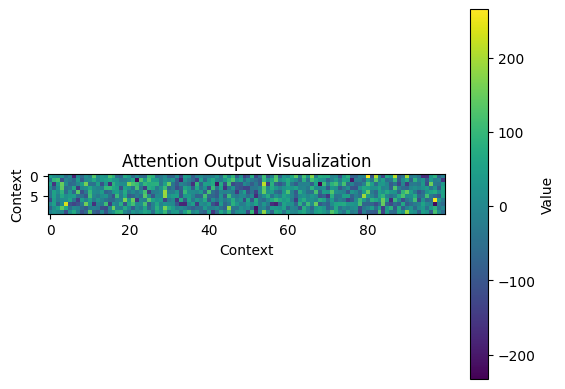

In [29]:
transform = Transformer(cfg)
print(x.shape)
output = transform(x)
print(output.shape)
# print(attn(x))
# print(mh_attn(x))

# visualize the attention scores
plt.imshow(output.detach().numpy()[:, :100], cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Attention Output Visualization")
plt.xlabel("Context")
plt.ylabel("Context")
plt.show()
# visualize the attention scores

torch.Size([10, 128])
torch.Size([10, 128])


C:\Users\hpfin\AppData\Local\Temp\ipykernel_20500\2586295814.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))


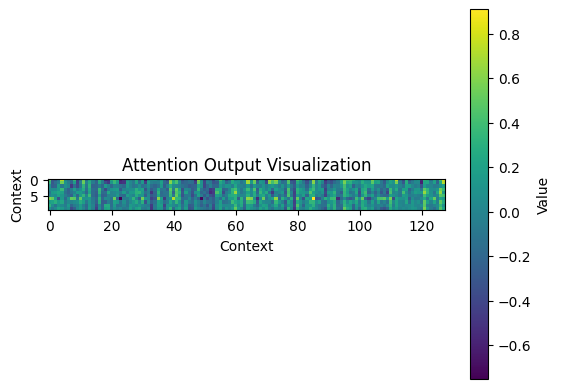

In [30]:
cfg = GPTConfig()

ah = AttentionHead(cfg)
x = torch.randn(10, cfg.d_model)
print(ah(x).shape)

output = ah.forward(x)
print(output.shape)


# visualize the attention scores
plt.imshow(output.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Attention Output Visualization")
plt.xlabel("Context")
plt.ylabel("Context")
plt.show()
# visualize the attention scores


In [31]:
from get_books import get_many_books
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset

tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Initialize tokenizer once
model_cfg = GPTConfig(d_model=128, d_vocab=tokenizer.vocab_size, n_heads=4, n_layers=6, d_mlp=512)

book_ids = [84, 85]  
dataset = get_many_books(book_ids, data_temp="./data/gutenberg_data")

rawtext = ""
for book in dataset:
    rawtext += book
tokens = tokenizer(rawtext, return_tensors="pt")

chunk_size = 10
to_remove = tokens["input_ids"].shape[1] % chunk_size
new_shape = tokens["input_ids"].shape[1] // chunk_size

attention_mask = tokens['attention_mask'][0][:-to_remove].reshape(new_shape, chunk_size)
input_ids = tokens['input_ids'][0][:-to_remove].reshape(new_shape, chunk_size)

tensor = TensorDataset(input_ids, attention_mask)

dataloader = DataLoader(tensor, batch_size=8, shuffle=True)

batch_size = 8
lr = 1e-3
weight_decay = 1e-2
print(input_ids.shape)
print(dataloader)

Getting book 84...
	426785 characters read
Getting book 84...
	359291 characters read


Token indices sequence length is longer than the specified maximum sequence length for this model (202757 > 1024). Running this sequence through the model will result in indexing errors


torch.Size([20275, 10])


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

# Move model to GPU if available
device = torch.device("cpu")
model = Transformer(model_cfg)
model = model.to(device)

# Set up optimizer and loss
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model.train()
n_epochs = 1
print_interval = 10

for epoch in range(n_epochs):
    for step, batch in enumerate(dataloader):
        # [batch_size, seq_len]
        input_ids_batch = batch[0].to(device)

        # We'll accumulate the losses for each sequence in this mini-batch
        total_loss = 0.0
        batch_size = input_ids_batch.size(0)

        # Process each sequence individually
        for i in range(batch_size):
            # Extract a single sequence of shape [seq_len]
            seq_ids = input_ids_batch[i]

            # Next-token language modeling: input is all but last token, target is all but first
            inp = seq_ids[:-1]    # shape [seq_len - 1]
            targ = seq_ids[1:]    # shape [seq_len - 1]

            # Forward pass
            # Your model returns logits of shape [seq_len-1, d_vocab]
            logits = model(inp)

            # Compute loss across this sequence
            # CrossEntropyLoss expects [batch, vocab], so we can pass [seq_len-1, d_vocab] vs. [seq_len-1]
            loss = criterion(logits, targ)

            # Accumulate
            total_loss += loss

        # Average across all sequences in the batch
        total_loss = total_loss / batch_size

        # Backprop and update
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Print progress
        if (step + 1) % print_interval == 0:
            print(f"Epoch {epoch+1}, Step {step+1}, Loss: {total_loss.item():.4f}")


C:\Users\hpfin\AppData\Local\Temp\ipykernel_20500\2586295814.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))


Epoch 1, Step 10, Loss: 240.3258
Epoch 1, Step 20, Loss: 275.3636
Epoch 1, Step 30, Loss: 308.6019
Epoch 1, Step 40, Loss: 347.2033
Epoch 1, Step 50, Loss: 365.6271
Epoch 1, Step 60, Loss: 335.3066
Epoch 1, Step 70, Loss: 372.4445
Epoch 1, Step 80, Loss: 271.3581
Epoch 1, Step 90, Loss: 258.0663
Epoch 1, Step 100, Loss: 304.6628
Epoch 1, Step 110, Loss: 281.5866
Epoch 1, Step 120, Loss: 229.0878


KeyboardInterrupt: 